In [34]:
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt
from pandas.plotting import table
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
from collections import Counter
import re

In [2]:
# Change this to name of the current spreadsheet you are working with by copying relative path
csv_file = "C:\\Users\\eunzz\\Downloads\\SFMTA Commuter Shuttle Data\\Shuttle Complaint Project\\ShuttleComplaints8.14.24UTF.csv"
df = pd.read_csv(csv_file)

In [3]:
df = df.rename(columns={
    'Case Owner': 'Case_Owner',
    'Description': 'Description',
    'Date/Time Opened': 'Date_Time_Opened',
    'Open': 'Open',
    'Closed': 'Closed',
    'Status': 'Status',
    'Case Last Modified Date': 'Case_Last_Modified_Date',
    'Organization Name': 'Organization_Name',
    'Case Record Type': 'Case_Record_Type'
})

print(df.columns)

Index(['Case_Owner', 'Description', 'Date_Time_Opened', 'Open', 'Closed',
       'Status', 'Case_Last_Modified_Date', 'Organization_Name',
       'Case_Record_Type'],
      dtype='object')


In [16]:
# Convert necessary columns to datetime
df['Date_Time_Opened'] = pd.to_datetime(df['Date_Time_Opened'], format='%m/%d/%Y, %I:%M %p')
df['Case_Last_Modified_Date'] = pd.to_datetime(df['Case_Last_Modified_Date'])

In [5]:

# Get the date range of all complaints
date_range = (df['Date_Time_Opened'].min(), df['Date_Time_Opened'].max())
print("Complete Date/Time Range:")
print(date_range)

Complete Date/Time Range:
(Timestamp('2018-01-12 09:21:00'), Timestamp('2020-03-09 16:26:00'))


<Axes: title={'center': 'Monthly Complaints Over Time'}, xlabel='Date_Time_Opened'>

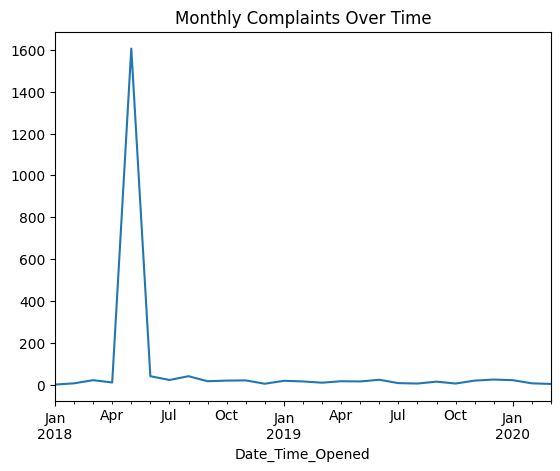

In [6]:
# Monthly complaints over time
df['Date_Time_Opened'] = pd.to_datetime(df['Date_Time_Opened'])
monthly_complaints = df.resample('M', on='Date_Time_Opened').size()
monthly_complaints.plot(title='Monthly Complaints Over Time')

In [13]:
# Extract year and quarter from 'Date_Time_Opened'
df['Year'] = df['Date_Time_Opened'].dt.year
df['Quarter'] = df['Date_Time_Opened'].dt.quarter

# Group by quarter and year and count the number of complaints
quarterly_complaints = df.groupby(['Quarter', 'Year']).size().reset_index(name='Number_of_Complaints')

# Pivot table to have quarters as rows and years as columns
quarterly_complaints_pivot = quarterly_complaints.pivot(index='Quarter', columns='Year', values='Number_of_Complaints')

# Display the table
print(quarterly_complaints_pivot)

Year       2018  2019  2020
Quarter                    
1          30.0  45.0  33.0
2        1658.0  57.0   NaN
3          81.0  29.0   NaN
4          46.0  51.0   NaN


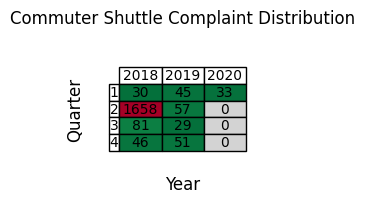

In [14]:
# Create a distribution table based on the year and split by quarter
distribution_table = df.groupby(['Year', 'Quarter']).size().unstack(fill_value=0)

# Transpose the table to have quarters as rows and years as columns
distribution_table = distribution_table.T

# Normalize the data for color mapping (between 0 and 1)
normed_data = (distribution_table - distribution_table.min().min()) / (distribution_table.max().max() - distribution_table.min().min())

# Create the plot
fig, ax = plt.subplots(figsize=(1.5, 1.5))

# Hide axes
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Create the table with color mapping
table = ax.table(cellText=distribution_table.values,
                 rowLabels=distribution_table.index,
                 colLabels=distribution_table.columns,
                 cellLoc='center',
                 loc='center')

# Apply color mapping to the cells
colors = plt.cm.RdYlGn_r(normed_data)  # Red to green color map

for i in range(len(distribution_table.index)):
    for j in range(len(distribution_table.columns)):
        if distribution_table.iloc[i, j] == 0:
            table[(i+1, j)].set_facecolor('lightgrey')  # Set color for zero values
        else:
            table[(i+1, j)].set_facecolor(colors[i, j])  # Set color based on normalized data

# Adjust the font size
table.auto_set_font_size(False)
table.set_fontsize(10)

# Adjust the column width to fit the content
table.auto_set_column_width(col=list(range(len(distribution_table.columns))))

# Add titles for row and column labels
ax.set_title('Commuter Shuttle Complaint Distribution', pad=20)
ax.text(-0.5, 0.5, 'Quarter', va='center', rotation='vertical', fontsize=12, transform=ax.transAxes)
ax.text(0.5, -0.2, 'Year', ha='center', fontsize=12, transform=ax.transAxes)

# Show the plot
plt.show()

<Axes: title={'center': 'Complaints by Case Owner'}>

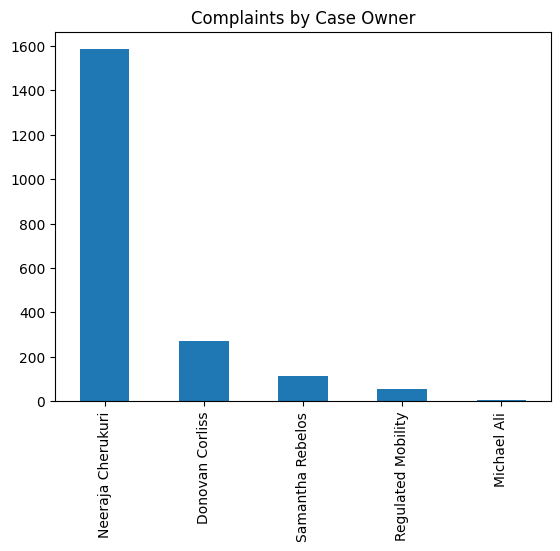

In [25]:
owner_complaints = df['Case_Owner'].value_counts()
owner_complaints.plot(kind='bar', title='Complaints by Case Owner')

<Axes: title={'center': 'Complaints by Organization'}>

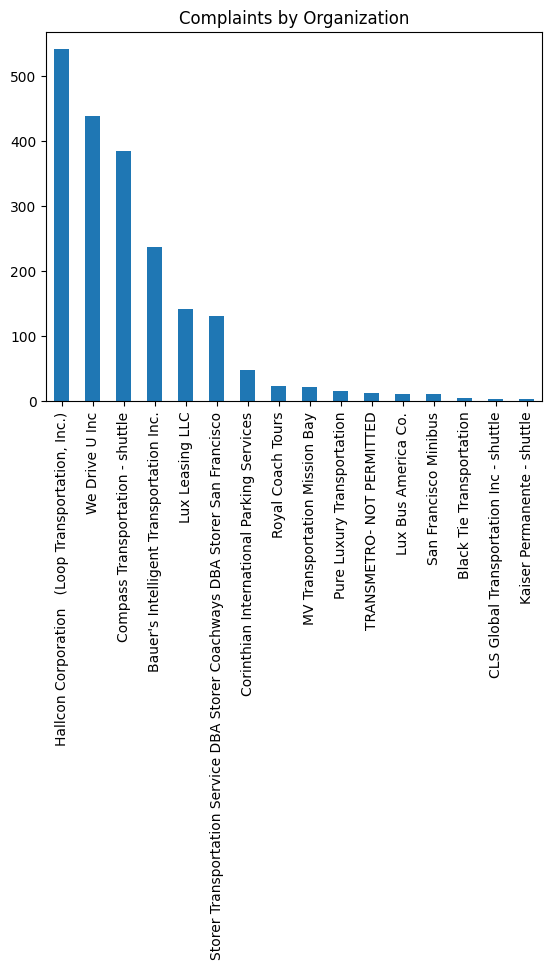

In [22]:
org_complaints = df['Organization_Name'].value_counts()
org_complaints.plot(kind='bar', title='Complaints by Organization')

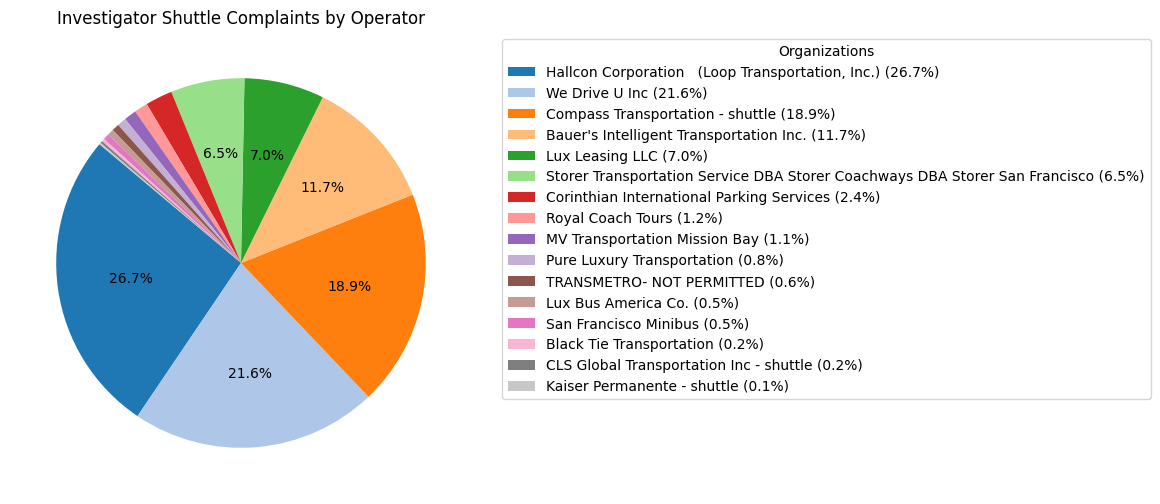

In [ ]:
# Count occurrences of each organization
org_counts = df['Organization_Name'].value_counts()

# Calculate percentages
percentages = org_counts / org_counts.sum() * 100

# Create a list of labels for the legend
legend_labels = [f'{org} ({pct:.1f}%)' for org, pct in zip(org_counts.index, percentages)]

# Define a function to format percentages
def format_autopct(pct):
    return f'{pct:.1f}%' if pct >= 2.5 else ''

# Plot pie chart
plt.figure(figsize=(8, 6))
wedges, texts, autotexts = plt.pie(org_counts, autopct=lambda pct: format_autopct(pct),
                                   startangle=140, colors=plt.get_cmap('tab20').colors)

# Remove labels (texts) from the chart
for text in texts:
    text.set_visible(False)

# Add legend
plt.legend(legend_labels, title='Organizations', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Investigator Shuttle Complaints by Operator')
plt.show()

In [21]:
# Create a new column with just the date part of 'Date_Time_Opened'
df['Date_Opened'] = df['Date_Time_Opened'].dt.date

# Calculate the difference between 'Case_Last_Modified_Date' and 'Date_Opened'
df['Days_to_Last_Modified'] = (df['Case_Last_Modified_Date'].dt.date - df['Date_Opened']).apply(lambda x: x.days)

# Compute the average and distribution of 'Days_to_Last_Modified'
average_days_to_last_modified = df['Days_to_Last_Modified'].mean()
distribution_days_to_last_modified = df['Days_to_Last_Modified'].describe()

# Display results
print("Average # of Days from Opened to Last Modified")
print(average_days_to_last_modified)

print("\nDistribution of Days to Last Modified:")
print(distribution_days_to_last_modified)

Average # of Days from Opened to Last Modified
4.331527093596059

Distribution of Days to Last Modified:
count    2030.000000
mean        4.331527
std        21.815638
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       196.000000
Name: Days_to_Last_Modified, dtype: float64


In [26]:
closure_rate = df['Closed'].notna().sum() / df.shape[0]
print(f'Closure Rate: {closure_rate:.2%}')

Closure Rate: 100.00%


In [28]:
# There is a weak negative correlation between resolution & response time
correlation_matrix = df[['Response_Time', 'Resolution_Time']].corr()
print(correlation_matrix)

                 Response_Time  Resolution_Time
Response_Time         1.000000        -0.184894
Resolution_Time      -0.184894         1.000000


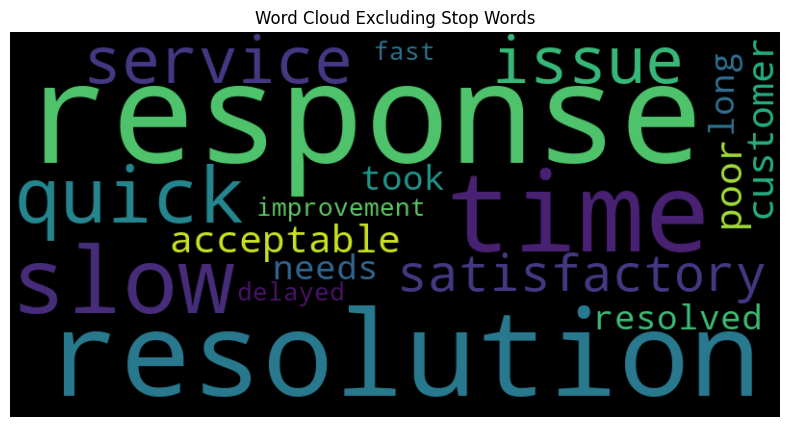

In [35]:
stop_words = set([
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves',
    'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their',
    'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was',
    'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and',
    'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between',
    'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off',
    'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any',
    'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
    'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now'
])

# Combine all text from 'Description' column into a single string
text = ' '.join(df['Description'].dropna().str.lower())

# Remove punctuation and non-alphanumeric characters
text = re.sub(r'[^\w\s]', '', text)

# Split text into words and filter out stop words
filtered_words = [word for word in text.split() if word not in stop_words]

# Join filtered words back into a single string
filtered_text = ' '.join(filtered_words)

# Create the word cloud with a black background
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(filtered_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axes
plt.title('Word Cloud Excluding Stop Words')
plt.show()